# Topic 2 C - PCA vs LDA (Wine Quality Red) — Visual Comparison

**Corresponding script:**
- `scripts/exercises/pca_vs_lda_ex4.py`

**Dataset:**
- `datasets/raw/Topic2/winequalityred.csv`

## Learning goals
- Convert a real target into a smaller number of classes (binning)
- Compare **PCA (unsupervised)** vs **LDA (supervised)** in 2D
- Interpret plots: “spread” (PCA) vs “class separation” (LDA)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 1) Load dataset

We try common repo paths:
- `../datasets/raw/winequalityred.csv`
- `./winequalityred.csv` (fallback)

If you keep your dataset only in the repo, the first path should work.


In [20]:
wine = pd.read_csv("../datasets/raw/Topic2/winequalityred.csv")
wine.head()

,Unnamed: 0,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2) Create a 3-class target (as in Lecture 2)

Original `quality` has many values. For visualization, we group them into 3 classes:

- class 1: quality ≤ 4  (low)
- class 2: quality 5–6  (medium)
- class 3: quality ≥ 7  (high)

This creates a multiclass label `quality2` so we can compare PCA and LDA.


In [26]:
wine["quality2"] = np.where(
    wine["quality"] <= 4, 1,
    np.where(wine["quality"] <= 6, 2, 3)
)

# If the file contains an index column like Unnamed: 0, drop it if present
drop_cols = [c for c in ["Unnamed: 0", "quality", "quality2"] if c in wine.columns]

X = wine.drop(columns=drop_cols)
y = wine["quality2"].to_numpy()

print("X shape:", X.shape)
print("Class counts (1/2/3):", np.bincount(y)[1:])

X shape: (1599, 11)
Class counts (1/2/3): [  63 1319  217]


## 3) Standardize X

Both PCA and LDA are sensitive to scaling (variance/covariance).
We standardize so features are comparable.


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4) Fit PCA (2 components)

PCA ignores labels and projects data into 2D by preserving maximum variance:

- PC1 captures most variance
- PC2 captures next most variance, orthogonal to PC1


In [23]:
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))
print("PCA total (2D):", np.round(pca.explained_variance_ratio_.sum(), 4))

PCA explained variance ratio: [0.2817 0.1751]
PCA total (2D): 0.4568


## 5) Fit LDA (2 components)

LDA uses labels and projects into 2D to maximize class separability.

Since we have **3 classes**, max components is:

$$
C - 1 = 2
$$

So 2D LDA is valid here.


In [24]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda.fit(X_scaled, y).transform(X_scaled)

# LDA explained_variance_ratio_ exists for multiclass with solver='svd'
if hasattr(lda, "explained_variance_ratio_"):
    print("LDA explained variance ratio:", np.round(lda.explained_variance_ratio_, 4))
    print("LDA total (2D):", np.round(lda.explained_variance_ratio_.sum(), 4))

LDA explained variance ratio: [0.8306 0.1694]
LDA total (2D): 1.0


## 6) Plot PCA vs LDA side-by-side (in 2D)

Interpretation guide:
- PCA usually looks more “spread out” (variance-driven)
- LDA often creates tighter clusters by class (separation-driven)

We avoid manually setting colors: matplotlib will cycle colors by default.


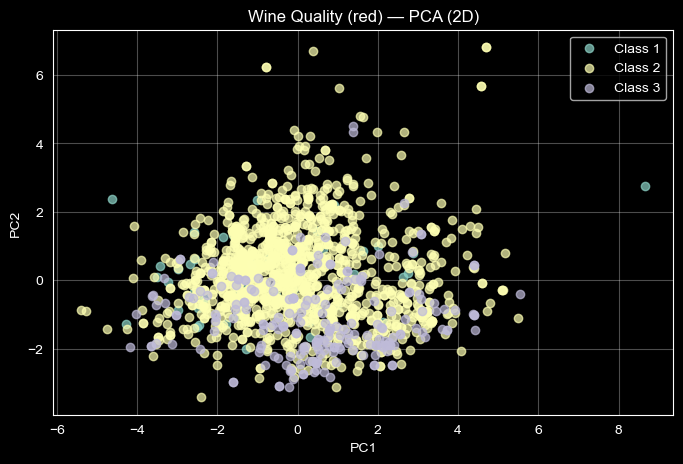

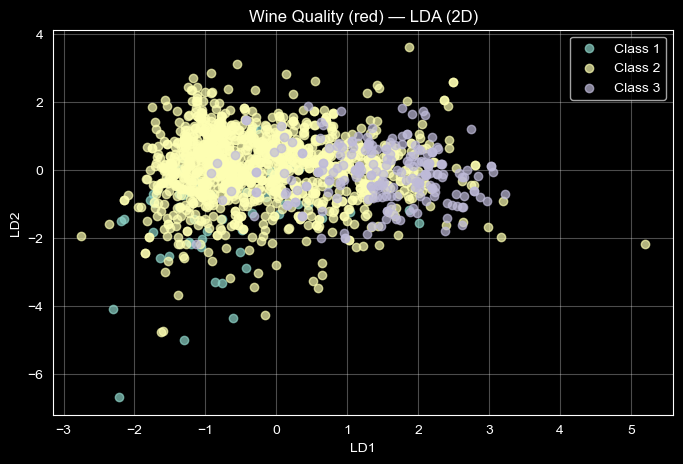

In [25]:
classes = np.unique(y)

plt.figure(figsize=(8, 5))
for cls in classes:
    mask = (y == cls)
    plt.scatter(X_pca2[mask, 0], X_pca2[mask, 1], alpha=0.7, label=f"Class {cls}")
plt.title("Wine Quality (red) — PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))
for cls in classes:
    mask = (y == cls)
    plt.scatter(X_lda2[mask, 0], X_lda2[mask, 1], alpha=0.7, label=f"Class {cls}")
plt.title("Wine Quality (red) — LDA (2D)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ✅ Interpretation of results (Topic 2C — PCA vs LDA on red wine)

### Dataset context (class imbalance)
- X shape: **(1599, 11)**
- Class counts: **[63, 1319, 217]** → strongly imbalanced (Class 2 dominates)

This imbalance affects both visualization and classification: minority classes can be harder to separate.

---

### PCA (2D) interpretation
- PCA explained variance ratio: **[0.2817, 0.1751]**
- Total variance shown in 2D: **0.4568 (45.68%)**

PCA chooses directions that preserve **maximum variance** in X (unsupervised).
It does **not** use labels, so separation between classes is not guaranteed in PC1/PC2.

Result: PCA plot shows a large overlapping cloud (not strong separation).

---

### LDA (2D) interpretation
- LDA explained variance ratio: **[0.8306, 0.1694]**
- Total (LD1 + LD2): **1.0**

LDA is supervised and chooses directions that maximize class separability.
Because we have **C = 3 classes**, LDA can create at most:

$$
n_{\text{components}} \le C - 1 = 2
$$

So LD1 and LD2 represent the full discriminant space available for these classes, which is why the total is **1.0**.

Result: LDA plot shows clearer class ordering/separation (especially along LD1), even if overlap remains.

---

### Main takeaway
- **PCA preserves variance**
- **LDA preserves class separability**
- When labels exist and the goal is classification, LDA often produces a more informative low-dimensional view than PCA.